In [ ]:
import pandas as pd
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.io import loadmat
from scipy.io import arff
from collections import deque

torch.manual_seed(42)
np.random.seed(42)
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"CUDA version: {torch.version.cuda}")
device


Is CUDA supported by this system? True
CUDA version: 11.3


'cuda'

In [ ]:

# generate a random hypervector of -1 and 1s
def generate_random_hypervector(dim):
    res = torch.randint(low=0, high=2, size=(dim,), device=device, dtype=torch.float64) # create random 0,1 vector
    res.mul_(2) # makes it 0,2 vector
    res.sub_(1) # makes it -1,1 vector
    return res

# generate a random hypermatrix of -1 and 1s
def generate_id_matrix(n_features=617, dim=1000):
    res = torch.randint(low=0, high=2, size=(n_features, dim), device=device, dtype=torch.float64) # create random 0,1 vector
    res.mul_(2) # makes it 0,2 vector
    res.sub_(1) # makes it -1,1 vector
    return res

class Encoder:
    def __init__(self, dim=1000, timestep=1, y_max=1, y_min=0, sensitivity=200):
        self.dim = dim
        self.y_max_hd = generate_random_hypervector(self.dim)
        self.y_min_hd = self.y_max_hd*-1
        # self.y_min_hd = generate_random_hypervector(self.dim)
        # self.y_max_hd = torch.ones(self.dim).to(device)
        # self.y_min_hd = torch.ones(self.dim).to(device)-2
        self.y_max = y_max
        self.y_min = y_min
        self.sensitivity = sensitivity
        self.gap = (y_max-y_min) / self.sensitivity
        meta = np.linspace(y_min, y_max, self.sensitivity)
        self.position_hds = generate_id_matrix(timestep, dim)
        self.quantized = torch.zeros((meta.shape[0], self.dim)).to(device)
        for i, val in enumerate(meta):
            self.quantized[i] = self.interpolate(val)

    def interpolate(self, val):
        if pd.isnull(val):
          return 
        if val >= self.y_max:
            return torch.clone(self.y_max_hd)
        if val <= self.y_min:
            return torch.clone(self.y_min_hd)
        n_from_max = round((val.item() - self.y_min)/(self.y_max - self.y_min)*self.dim)
        # randomly choose "n_from_max" indices to copy from y_max_hd
        indices_from_max = np.random.choice(range(self.dim), size=n_from_max, replace=False)
        hd_vec = torch.clone(self.y_min_hd)
        hd_vec[indices_from_max] = self.y_max_hd[indices_from_max]
        return hd_vec

    def quantized_encode(self, val):
        ind = max(min(round((val - self.y_min) / self.gap), self.sensitivity-1), 0)
        return self.quantized[ind]

In [ ]:
class intESN():
    def __init__(self, n_inputs, n_outputs, n_reservoir=200,
                 noise=0.001,
                 random_state=None, silent=True, clip=7, q_in=None,
                 input_co=1, out_co=1):
        """
        Args:
            n_inputs: nr of input dimensions
            n_outputs: nr of output dimensions
            n_reservoir: nr of reservoir neurons
            noise: noise added to each neuron (regularization)
            random_state: positive integer seed, np.rand.RandomState object,
                          or None to use numpy's builting RandomState.
            silent: supress messages
        """
        # check for proper dimensionality of all arguments and write them down.
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.n_outputs = n_outputs
        self.noise = noise
        self.q_in = q_in

        self.silent = silent
        self.clip = clip
        self.input_co = input_co
        self.out_co = out_co

    def _update(self, state, input_pattern, output_pattern):
        """performs one update step.
        i.e., computes the next network state by applying the recurrent weights
        to the last state & and feeding in the current input and output patterns
        """
        for k in range(input_pattern.shape[0]):
            hd_input = torch.zeros((1, self.n_reservoir)).to(device)
            for j in range(input_pattern.shape[1]):
                if pd.isnull(input_pattern[k][j]):
                  break
                state = (torch.roll(state,-1, dims=(0)) # shift state by 1
                                + self.input_co * self.q_in((input_pattern[k][j]))
                                + self.out_co * output_pattern)
            hd_input.add_(state.mul_(variate_refs[k]))
        t = hd_input + self.noise * (torch.rand(self.n_reservoir).to(device) - 0.5)
        return torch.clip(t, -self.clip, self.clip)
        # return (t - t.min())/(t.max()-t.min()) * self.clip*2 - self.clip
        # return torch.tanh(t)

    def fit(self, inputs, outputs, outputs_hd, inspect=False):
        """
        Collect the network's reaction to training data, train readout weights.
        Args:
            inputs: array of dimensions (N_training_samples x n_inputs)
            outputs: array of dimension (N_training_samples x n_outputs)
            inspect: show a visualisation of the collected reservoir states
        Returns:
            the network's output on the training data, using the trained weights
        """
        if not self.silent:
            print("harvesting states...")
        N = len(inputs)
        
        # step the reservoir through the given input,output pairs:
        states = torch.zeros((N, self.n_reservoir)).float().to(device)
        for n in range(1, N):
            states[n, :] = self._update(states[n - 1,:], inputs[n],
                                        outputs_hd[n - 1, :])
        
        # learn the weights, i.e. find the linear combination of collected
        # network states that is closest to the target output
        if not self.silent:
            print("fitting...")
        # we'll disregard the first few states:
        transient = 0

        # include the raw inputs:
        # extended_states = torch.hstack((states, inputs)).float()
        extended_states = states

        # Solve for W_out:
        self.W_out = torch.matmul(torch.linalg.pinv(states[transient:, :]).float(),
                            outputs[transient:, :].float()).T

        # optionally visualize the collected states
        if inspect:
            from matplotlib import pyplot as plt
            # (^-- we depend on matplotlib only if this option is used)
            plt.figure(
                figsize=(states.shape[0] * 0.0025, states.shape[1] * 0.01))
            plt.imshow(extended_states.T, aspect='auto',
                       interpolation='nearest')
            plt.colorbar()

        if not self.silent:
            print("training error:")
        # apply learned weights to the collected states:
        pred_train = torch.matmul(extended_states, self.W_out.T)
        if not self.silent:
            print(torch.sqrt(torch.mean((pred_train - outputs)**2)))
        return pred_train

    def predict(self, inputs, continuation=True):
        """
        Apply the learned weights to the network's reactions to new input.
        Args:
            inputs: array of dimensions (N_test_samples x n_inputs)
            continuation: if True, start the network from the last training state
        Returns:
            Array of output activations
        """
        n_samples = len(inputs)

        laststate = torch.zeros((1,self.n_reservoir)).to(device)
        lastinput = inputs[0]
        lastoutput = torch.zeros((1,self.n_reservoir)).to(device)
        inputs = deque(inputs)
        inputs.appendleft(lastinput)
        states = torch.vstack(
            [laststate, torch.zeros((n_samples, self.n_reservoir)).to(device)])
        outputs = torch.zeros((states.shape[0], self.n_outputs)).to(device)
        outputs_encoded = torch.vstack([lastoutput, torch.zeros((n_samples, self.n_reservoir)).to(device)])
        for n in range(n_samples):
            states[n + 1, :] = self._update(states[n, :], inputs[n + 1], outputs_encoded[n, :])
            # extended_states = torch.hstack((states[n+1, :], inputs[n+1])).float()
            extended_states = states[n+1,:]
            outputs[n + 1, :] = torch.matmul(self.W_out, extended_states)
            outputs_encoded[n+1,:] = output_refs[outputs[n + 1, :].argmax()]

        return outputs[1:]

# Character Trajectories

In [ ]:
# Character Trajectories dataset
data = loadmat('/content/mixoutALL_shifted.mat', squeeze_me=True)
input = data['mixout']
labels = data['consts'].reshape((1))[0][4] - 1

In [ ]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19], dtype=uint8)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(input, labels, random_state=42, shuffle=True, train_size=300)
n_classes = len(np.unique(y_train))
print(X_train.shape, X_test.shape)

(300,) (2558,)


In [ ]:
n_classes = len(np.unique(y_train))
y_train_onehot = torch.eye(n_classes)[y_train.astype(np.int32)].to(device)
y_max = np.max([x.max() for x in X_train])
y_min = np.min([x.min() for x in X_train])
dims = [50, 75, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 5000, 10000, 15000, 20000]
accuracies_ch = np.zeros(len(dims))
for ind, dim in enumerate(dims):
    for run in range(5):
        encoder = Encoder(dim=dim, y_max=y_max, y_min=y_min)
        output_refs = generate_id_matrix(n_classes, dim) # generate hd for each class
        variate_refs = generate_id_matrix(X_train[0].shape[0], dim)
        hd_y_train = output_refs[y_train.astype(np.int32)]

        esn = intESN(n_inputs=1, n_outputs=n_classes, n_reservoir=dim, clip=3, q_in=encoder.quantized_encode)
        esn.fit(X_train, y_train_onehot, hd_y_train)
        preds = esn.predict(X_test, continuation=False)
        preds = preds.argmax(dim=1)
        acc = np.sum(preds.cpu().numpy() == y_test)/preds.shape[0]
        print(dim, acc)
        accuracies_ch[ind] = max(accuracies_ch[ind], acc)

ValueError: ignored

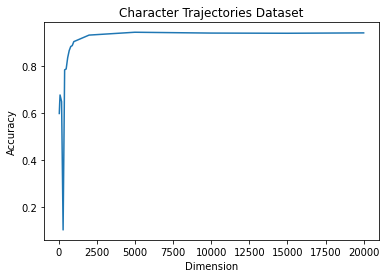

In [ ]:
plt.plot(dims, accuracies_ch)
plt.xlabel('Dimension')
plt.ylabel('Accuracy')
plt.title('Character Trajectories Dataset')
plt.show()

In [ ]:
accuracies_ch.max()

0.9437060203283816

# Spoken Arabic Digits

In [ ]:
# Spoken Arabic Digits dataset
train = pd.read_table('/content/Train_Arabic_Digit.txt', delimiter=' ', index_col=None)
test = pd.read_table('/content/Test_Arabic_Digit.txt', delimiter=' ', index_col=None)

In [ ]:
block_counter = 0
X_train, X_test = [], []
temp = []
y_train, y_test = [], []
for i in range(len(train)):
  row = train.iloc[i]
  if pd.isnull(row[0]) or i == len(train)-1:
    X_train.append(np.array(temp).T)
    temp = []
    y_train.append(block_counter // 660)
    block_counter += 1
  else:
    temp.append(row)
block_counter = 0
temp = []
for i in range(len(test)):
  row = test.iloc[i]
  if pd.isnull(row[0]) or i == len(test)-1:
    X_test.append(np.array(temp).T)
    temp = []
    y_test.append(block_counter // 220)
    block_counter += 1
  else:
    temp.append(row)

y_train = np.array(y_train, dtype=np.int32)
y_test = np.array(y_test, dtype=np.int32)

In [ ]:
n_classes = len(np.unique(y_train))
y_train_onehot = torch.eye(n_classes)[y_train.astype(np.int32)].to(device)
y_max = np.max([x.max() for x in X_train])
y_min = np.min([x.min() for x in X_train])
dims = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 5000, 10000, 15000, 20000]
accuracies = np.zeros(len(dims))
for ind, dim in enumerate(dims):
    for run in range(5):
        encoder = Encoder(dim=dim, y_max=y_max, y_min=y_min)
        output_refs = generate_id_matrix(n_classes, dim) # generate hd for each class
        variate_refs = generate_id_matrix(X_train[0].shape[0], dim)
        hd_y_train = output_refs[y_train.astype(np.int32)]

        esn = intESN(n_inputs=1, n_outputs=n_classes, n_reservoir=dim, clip=7, q_in=encoder.quantized_encode)
        esn.fit(X_train, y_train_onehot, hd_y_train)
        preds = esn.predict(X_test, continuation=False)
        preds = preds.argmax(dim=1)
        acc = np.sum(preds.cpu().numpy() == y_test)/preds.shape[0]
        print(dim, acc)
        accuracies[ind] = max(accuracies[ind], acc)

100 0.14272727272727273
100 0.1690909090909091
100 0.16136363636363638
100 0.16772727272727272
100 0.15363636363636363
200 0.12363636363636364
200 0.195
200 0.17681818181818182
200 0.21227272727272728
200 0.13863636363636364
300 0.25136363636363634
300 0.22136363636363637
300 0.15227272727272728
300 0.15181818181818182
300 0.18681818181818183
400 0.21681818181818183
400 0.14772727272727273
400 0.21863636363636363
400 0.16727272727272727
400 0.22363636363636363
500 0.2009090909090909
500 0.15454545454545454
500 0.22045454545454546
500 0.28545454545454546
500 0.2459090909090909
600 0.19636363636363635
600 0.24136363636363636
600 0.20363636363636364
600 0.4431818181818182
600 0.20681818181818182
700 0.2590909090909091
700 0.10772727272727273
700 0.2081818181818182
700 0.25136363636363634
700 0.2309090909090909
800 0.2290909090909091
800 0.3568181818181818
800 0.22727272727272727
800 0.26227272727272727
800 0.38272727272727275
900 0.10181818181818182
900 0.13727272727272727
900 0.352727272

KeyboardInterrupt: ignored

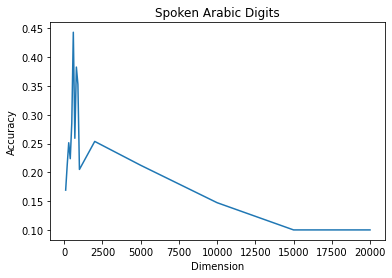

In [ ]:
plt.plot(dims, accuracies)
plt.xlabel('Dimension')
plt.ylabel('Accuracy')
plt.title('Spoken Arabic Digits')
plt.show()

# Japanese Vowels

In [ ]:
!pip install sktime -q

     |████████████████████████████████| 6.7 MB 6.7 MB/s 
     |████████████████████████████████| 9.8 MB 61.7 MB/s 
     |████████████████████████████████| 3.3 MB 51.5 MB/s 
     |████████████████████████████████| 34.5 MB 103.2 MB/s 


In [ ]:
import numpy as np
import sktime
from sktime.datasets import load_from_arff_to_dataframe
train = load_from_arff_to_dataframe('/content/JapaneseVowels_TRAIN.arff')
X_train = train[0].to_numpy()
y_train = np.subtract(train[1].astype(np.int32).reshape((-1, 1)), 1)
test = load_from_arff_to_dataframe('/content/JapaneseVowels_TEST.arff')
X_test = test[0].to_numpy()
y_test =  np.subtract(test[1].astype(np.int32).reshape((-1, 1)), 1)
# decoder.decode(file_, encode_nominal=True)
# dataset = arff.load(open('/content/JapaneseVowels_TRAIN.arff', 'r'), encode_nominal=False)
# data = np.array(dataset['data'])

In [ ]:
X_train.shape, X_test.shape
X_train = [np.array([np.array(y) for y in x]).reshape((12, -1)) for x in X_train]
X_test = [np.array([np.array(y) for y in x]).reshape((12, -1)) for x in X_test]

In [ ]:
X_train[0].shape

(12, 29)

In [ ]:
n_classes = len(np.unique(y_train))
y_train_onehot = torch.eye(n_classes)[y_train.astype(np.int32)].to(device).reshape((-1, n_classes))
y_max = float('-inf')
y_min = float('inf')
for x in X_train:
  for y in x:
    for z in y:
      if not pd.isnull(z):
        y_max = max(z, y_max)
        y_min = min(z, y_min)
dims1 = [50, 75, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 5000, 10000, 15000, 20000]
dims = [40000, 50000, 80000, 100000]
accuracies2 = np.zeros(len(dims))
for ind, dim in enumerate(dims):
    for run in range(5):
        for sens in [50, 100, 200, 500]:
          encoder = Encoder(dim=dim, y_max=y_max, y_min=y_min, sensitivity=sens)
          output_refs = generate_id_matrix(n_classes, dim) # generate hd for each class
          variate_refs = generate_id_matrix(X_train[0].shape[0], dim)
          hd_y_train = output_refs[y_train.astype(np.int32)]

          esn = intESN(n_inputs=1, n_outputs=n_classes, n_reservoir=dim, clip=7, q_in=encoder.quantized_encode)
          esn.fit(X_train, y_train_onehot, hd_y_train)
          preds = esn.predict(X_test, continuation=False)
          preds = preds.argmax(dim=1)
          acc = np.sum(preds.cpu().numpy().reshape(-1, 1) == y_test)/preds.shape[0]
          print(dim, acc)
          accuracies2[ind] = max(accuracies2[ind], acc)

40000 0.15135135135135136
40000 0.0972972972972973
40000 0.12702702702702703
40000 0.1
40000 0.14594594594594595
40000 0.10270270270270271
40000 0.13513513513513514
40000 0.15675675675675677
40000 0.1945945945945946
40000 0.14864864864864866
40000 0.11081081081081082
40000 0.12702702702702703
40000 0.13513513513513514
40000 0.10540540540540541
40000 0.11891891891891893
40000 0.12702702702702703
40000 0.10270270270270271
40000 0.12972972972972974
40000 0.1
40000 0.11621621621621622
50000 0.2
50000 0.16486486486486487
50000 0.10540540540540541
50000 0.15405405405405406
50000 0.10540540540540541
50000 0.13243243243243244
50000 0.13783783783783785
50000 0.13783783783783785
50000 0.17027027027027028
50000 0.15945945945945947
50000 0.15135135135135136
50000 0.11621621621621622
50000 0.1810810810810811
50000 0.14594594594594595
50000 0.12432432432432433
50000 0.12162162162162163
50000 0.15135135135135136
50000 0.14324324324324325
50000 0.1
50000 0.11621621621621622
80000 0.15945945945945947
8

In [ ]:
dims2 = [120000, 150000, 180000, 200000, 300000, 500000]
accuracies3 = np.zeros(len(dims))
for ind, dim in enumerate(dims2):
    for run in range(5):
        for sens in [50, 100, 200, 500]:
          encoder = Encoder(dim=dim, y_max=y_max, y_min=y_min, sensitivity=sens)
          output_refs = generate_id_matrix(n_classes, dim) # generate hd for each class
          variate_refs = generate_id_matrix(X_train[0].shape[0], dim)
          hd_y_train = output_refs[y_train.astype(np.int32)]

          esn = intESN(n_inputs=1, n_outputs=n_classes, n_reservoir=dim, clip=7, q_in=encoder.quantized_encode)
          esn.fit(X_train, y_train_onehot, hd_y_train)
          preds = esn.predict(X_test, continuation=False)
          preds = preds.argmax(dim=1)
          acc = np.sum(preds.cpu().numpy().reshape(-1, 1) == y_test)/preds.shape[0]
          print(dim, acc)
          accuracies3[ind] = max(accuracies3[ind], acc)

120000 0.15945945945945947
120000 0.13783783783783785
120000 0.1783783783783784
120000 0.12702702702702703
120000 0.12702702702702703
120000 0.1972972972972973
120000 0.17567567567567569
120000 0.15945945945945947
120000 0.14054054054054055
120000 0.16756756756756758
120000 0.12702702702702703
120000 0.16486486486486487
120000 0.08648648648648649
120000 0.1972972972972973
120000 0.12702702702702703
120000 0.10810810810810811
120000 0.22162162162162163
120000 0.16216216216216217
120000 0.14324324324324325
120000 0.12432432432432433
150000 0.23513513513513515
150000 0.14324324324324325
150000 0.14054054054054055
150000 0.07567567567567568
150000 0.17027027027027028
150000 0.14324324324324325
150000 0.15135135135135136
150000 0.1945945945945946
150000 0.17297297297297298
150000 0.15405405405405406
150000 0.14054054054054055
150000 0.15135135135135136
150000 0.1864864864864865
150000 0.15675675675675677
150000 0.12972972972972974
150000 0.0972972972972973
150000 0.1783783783783784
150000 0

IndexError: ignored

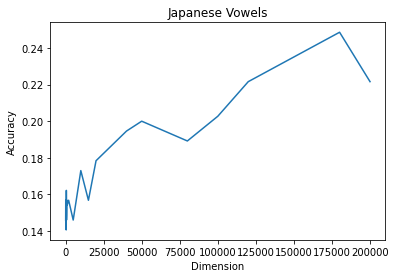

In [ ]:
plt.plot(dims1 + dims + dims2[:-2], np.hstack([accuracies, accuracies2, accuracies3]))
plt.xlabel('Dimension')
plt.ylabel('Accuracy')
plt.title('Japanese Vowels')
plt.show()

In [ ]:
np.hstack([accuracies, accuracies2, accuracies3]).max()

0.24864864864864866